In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import pathlib
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [8]:
DATASET_SIZE = 2000
INFORMATIVE_F = 2
DISTRACTOR_F = 2
out_file = "linear_sm.npz"
data = "wv_linear_sm"
data_dir = f"datasets/{data}"


## informative features

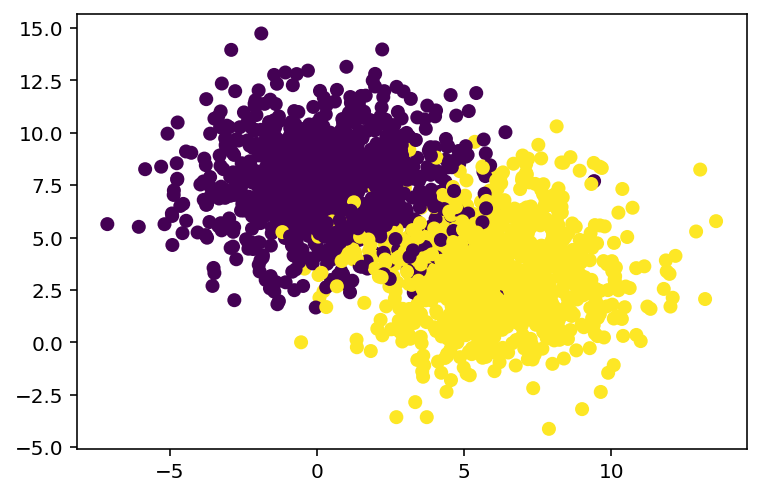

In [44]:
X,y = datasets.make_blobs(DATASET_SIZE, centers=2,cluster_std=2.2)
plt.scatter(X[:,0],X[:,1],c=y)

In [ ]:
w=-6
b=3.7
xd = np.array([-5,5])
# yd = w*xd + b
# plt.plot(xd, yd, 'k', lw=3, ls='--')
plt.scatter(X[:,0],X[:,1], s=50,c=y,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.xlim(min(X[:,0]),max(X[:,0]))
plt.ylim(min(X[:,1]),max(X[:,1]))
plt.show()

## distracting features

In [45]:
x3x4 = np.random.random([DATASET_SIZE,DISTRACTOR_F])
X = np.hstack([X,x3x4])

In [46]:
normalized_X = [normalize(X[:,i]) for i in range(X.shape[1])]
normalized_X = np.vstack(normalized_X).T

In [47]:
np.savez(out_file, X=normalized_X, y=y)

## gen df

In [48]:
X = normalized_X

In [49]:
features = ["head size","body size","tail size","texture"]
df = pd.DataFrame(X, columns=features)
df.insert(0, "label", y)

In [50]:
img_id = []
for i in range(DATASET_SIZE):
    if i < 10:
        img = f"00{i}.png"
    elif i >= 10 and i < 100:
        img = f"0{i}.png"
    else:
        img = f"{i}.png"
    img_id.append(img)
df.insert(0, "img_id", img_id)

In [55]:
data_dir = f"datasets/{data}"
pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)
df.to_csv(os.path.join(data_dir,"df.csv"),index=False)

## borderless plot

In [41]:
features = ["head size","body size"]
assert(len(df)==DATASET_SIZE)

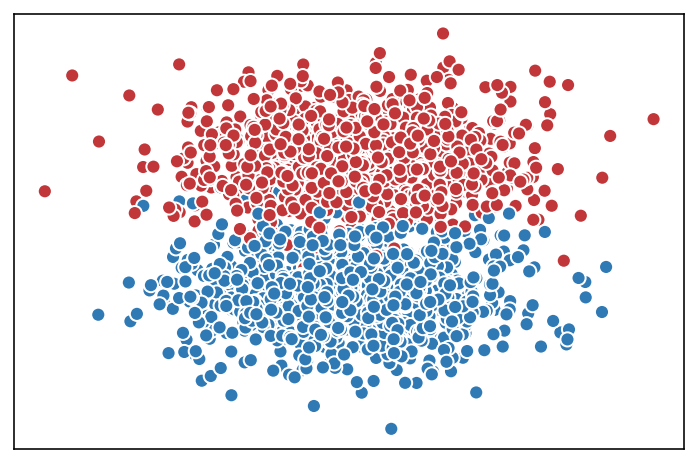

In [42]:
plt.scatter(df[features[0]],df[features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

## data splitting

In [24]:
df = pd.read_csv(os.path.join(data_dir,"df.csv"))

In [26]:
raw_data_dir = os.path.join(data_dir, "raw_imgs")
split_dir =  os.path.join(data_dir, "data")
for i in range(DATASET_SIZE):
    img_id = df.iloc[i]["img_id"]
    label = df.iloc[i]["label"]
    src = os.path.join(raw_data_dir,img_id)
    dst = os.path.join(split_dir,str(label))
    pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
    shutil.copy(src, dst)

In [21]:
total = np.arange(DATASET_SIZE)
valid = np.random.choice(total, int(DATASET_SIZE*0.2), replace=False)
total = np.setdiff1d(total, valid)
test = np.random.choice(total, int(DATASET_SIZE*0.2), replace=False)
total = np.setdiff1d(total, test)
train = total
train_df = df.iloc[train]
valid_df = df.iloc[valid]
test_df = df.iloc[test]

In [22]:
for split, df in zip(["train","valid","test"],[train_df,valid_df,test_df]):
    for i in range(len(df)):
        img_id = df.iloc[i]["img_id"]
        label = df.iloc[i]["label"]
        src = os.path.join(raw_data_dir,img_id)
        dst = os.path.join(data_dir,split,str(label))
        pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
        shutil.copy(src,dst)

## synthetic features.pkl

In [28]:
df = pd.read_csv(os.path.join(data_dir,"df.csv"))

In [29]:
for split in ["train","valid","test"]:
    files = utils.dataset_filenames(os.path.join(data_dir,split))
    files = [x.split("/")[-1] for x in files[:,0]]
    features = np.array([list(df[df["img_id"]==f][["head size","body size","tail size","texture"]].iloc[0]) for f in files])
    pickle.dump(features,open(f"{data_dir}/{split}_features.pkl","wb"))